# 1. Google Drive Connection

In [ ]:
# 드라이브 연결하기 Google Drive
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
pwd

'/content'

In [ ]:
# 작업하기 쉽게 위치 변경하기 Directory Change
%cd /content/gdrive/MyDrive/changdae

/content/gdrive/MyDrive/changdae


# 2. library & gpu

In [ ]:
# import library

import time
import os
import copy

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
# 8.2

if torch.cuda.is_available():
    device = torch.device('cuda')          
else:
    device = torch.device('cpu')
    
print('device:', device)

device: cuda


## data

In [ ]:

# Training을 위한 데이터 확장과 데이터셋 정규화

train_transforms = transforms.Compose([
        transforms.Resize((244, 244)), # 리사이즈
        transforms.RandomHorizontalFlip(),  # 좌우반전
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# Test를 위해서는 데이터셋 정규화만

test_transforms = transforms.Compose([
        transforms.Resize((244, 244)),             # 리사이즈
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


In [ ]:
pwd

'/content/gdrive/MyDrive/changdae'

# hyperparameter

In [ ]:
# hyperparameter
num_epochs = 15
num_classes = 2
batch_size = 10
learning_rate = 0.001

In [ ]:
# ImageFolder를 사용하여 폴더 안에 있는 이미지들을 데이터셋으로 사용

# truncated 문제 해결
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

train_dataset = datasets.ImageFolder('train', train_transforms)
test_dataset = datasets.ImageFolder('val', test_transforms)

train_loader = DataLoader( train_dataset, batch_size=batch_size, shuffle=True )
test_loader = DataLoader( test_dataset, batch_size=batch_size, shuffle=True )

# 분류 클래스 2개: poison, not_poison

class_names = train_dataset.classes
print(class_names)

['not_poison', 'poison']


#### preview data

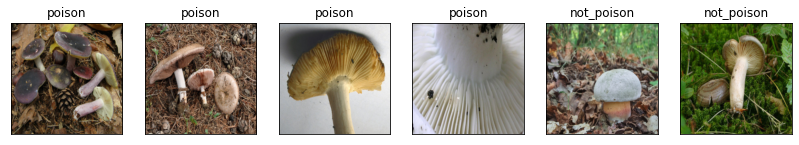

In [ ]:
# 8.7 데이터 미리보기

def convert_to_imshow_format(image):
    # from 3 x Height x Width to Height x Width x 3
    image = image.numpy().transpose(1,2,0)

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # convert back to [0,1] range from [-1,1] range
    image = image * std + mean
    image = np.clip(image, 0, 1)
    
    return image

dataiter = iter(train_loader)
# dataiter.next() 안 됨.
images, labels = next(dataiter)
images, labels = images[:6], labels[:6]

fig, axes = plt.subplots(1, len(images), figsize=(14,4))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(class_names[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

### Progress monitor
---

In [ ]:
# 8.8

from IPython.display import HTML, display

# Custom IPython progress bar for training
class ProgressMonitor(object):
    
    tmpl = """
        <table style="width: 100%;">
            <tbody>
                <tr>
                    <td style="width: 30%;">
                     <b>Epoch: {epoch}/{num_epochs} Loss: {loss:0.4f}</b> &nbsp&nbsp&nbsp {value} / {length}
                    </td>
                    <td style="width: 70%;">
                        <progress value='{value}' max='{length}', style='width: 100%'>{value}</progress>
                    </td>
                </tr>
            </tbody>
        </table>        
        """

    def __init__(self, length):
        self.length = length
        self.count = 0
        self.display = display(self.html(0, 0, 0, 0), display_id=True)
        
    def html(self, count, loss, epoch, num_epochs):
        return HTML(self.tmpl.format(length=self.length, value=count, loss=loss, epoch=epoch, num_epochs=num_epochs))
        
    def update(self, epoch, num_epochs, count, loss):
        self.count += count
        self.display.update(self.html(self.count, loss, epoch, num_epochs))

### Train Test
---

In [ ]:
# 8.11 Train

# 기존의 내용에서 scheduler만 추가됨
def train(epoch, num_epochs, model, optimizer, scheduler):

    # train phase
    model.train()
    
    # create a progress bar
    batch_loss_list = []
    progress = ProgressMonitor(length=len(train_dataset))

    for batch, target in train_loader:
        # Move the training data to the GPU
        batch, target = batch.to(device), target.to(device)

        # forward propagation
        output = model( batch )

        # calculate the loss
        loss = loss_func( output, target )
        
        # clear previous gradient computation
        optimizer.zero_grad()
 
        # backpropagate to compute gradients
        loss.backward()
 
        # update model weights
        optimizer.step()

        # update progress bar
        batch_loss_list.append(loss.item())
        progress.update(epoch, num_epochs, batch.shape[0], sum(batch_loss_list)/len(batch_loss_list) )

    # 스케쥴러의 스텝을 증가 - 때가 되면 학습률 변경
    if scheduler:
        scheduler.step()
    # 7번마다 한번씩 learning rate를 감소하기로 했으므로 step 증가하다가 넘으면 lr 감소

        

In [ ]:
def test(model):
    # test phase
    model.eval()

    correct = 0
    
    # We don't need gradients for test, so wrap in 
    # no_grad to save memory
    with torch.no_grad():
        for batch, target in test_loader:
            # Move the training batch to the GPU
            batch, target = batch.to(device), target.to(device)

            # forward propagation
            output = model( batch )

            # get prediction
            output = torch.argmax(output, 1)

            # accumulate correct number
            correct += (output == target).sum().item()

    # Calculate test accuracy    
    acc = 100 * float(correct) / len(test_dataset) 
    print( 'Test Acc: {}/{} ({:.2f}%)'.format( correct, len(test_dataset), acc ) )  
    
    return acc

### Finetuning the convnet
___

# 최종 점수
* VGG16: 89%
* Googlenet: 88%
* MNASnet: 86%
* Resnet18: 86%
* Alexnet: 79%

이 중 점수가 높았던 VGG16과 Googlenet을 epoch를 높여서 재학습 진행

# vgg16 

In [ ]:
# 8.9 Finetuning the ConvNet
# 파인튜닝 -> 전체 parameter 학습

# 미리 훈련된 Resnet18 가져와서
model_ft = models.vgg16(pretrained=True)
model_ft

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# 기존 classifier 지우고 새로 만들기
del(model_ft.classifier)

classifier = nn.Sequential(nn.Linear(in_features = 25088, out_features = 4096, bias = True),
                           nn.ReLU(),
                           nn.Dropout(p = 0.5),
                           nn.Linear(in_features = 4096, out_features = 4096, bias = True),
                            nn.ReLU(),
                            nn.Dropout(p = 0.5),
                            nn.Linear(in_features = 4096, out_features = 2, bias = True)
                        )
model_ft.add_module('classifier', classifier)

# 모델을 cuda로 이동
model_ft = model_ft.to(device)

# Cross entropy loss 사용
loss_func = nn.CrossEntropyLoss()

# SGD
optimizer_ft = optim.SGD( model_ft.parameters(), lr=0.001, momentum=0.9 )

# 매 30 epochs 마다 학습률에 0.1을 곱함
lr_scheduler_ft = optim.lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

In [ ]:
# 8.13

since = time.time()

# initialize the best weights
# 현재 모델의 state_dict를 저장하고 초기화함
best_model_weights = copy.deepcopy( model_ft.state_dict() )
best_acc = 0.0

for epoch in range(num_epochs):

    # train
    train(epoch+1, num_epochs, model_ft, optimizer_ft, lr_scheduler_ft )
    # test
    acc = test(model_ft)

    # update the best weights
    if acc > best_acc:
        best_acc = acc
        best_model_weights = copy.deepcopy( model_ft.state_dict() )

# load the best weights
model_ft.load_state_dict( best_model_weights )

# summary
time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best test accuracy: {:4f}'.format(best_acc))

torch.save(model_ft, 'model_vgg16_entire.pth')

Epoch: 1/50 Loss: 0.4969 4699 / 4699,4699


Test Acc: 1663/2013 (82.61%)


Epoch: 2/50 Loss: 0.3194 4699 / 4699,4699


Test Acc: 1674/2013 (83.16%)


Epoch: 3/50 Loss: 0.2243 4699 / 4699,4699


Test Acc: 1717/2013 (85.30%)


Epoch: 4/50 Loss: 0.1609 4699 / 4699,4699


Test Acc: 1749/2013 (86.89%)


Epoch: 5/50 Loss: 0.1209 4699 / 4699,4699


Test Acc: 1768/2013 (87.83%)


Epoch: 6/50 Loss: 0.0947 4699 / 4699,4699


Test Acc: 1791/2013 (88.97%)


Epoch: 7/50 Loss: 0.0710 4699 / 4699,4699


Test Acc: 1750/2013 (86.93%)


Epoch: 8/50 Loss: 0.0775 4699 / 4699,4699


Test Acc: 1765/2013 (87.68%)


Epoch: 9/50 Loss: 0.0627 4699 / 4699,4699


Test Acc: 1792/2013 (89.02%)


Epoch: 10/50 Loss: 0.0499 4699 / 4699,4699


Test Acc: 1690/2013 (83.95%)


Epoch: 11/50 Loss: 0.0358 4699 / 4699,4699


Test Acc: 1780/2013 (88.43%)


Epoch: 12/50 Loss: 0.0166 380 / 4699,380


KeyboardInterrupt: ignored

In [ ]:
model_ft.eval()
output_list = []
target_list = []
correct= 0

# no_grad to save memory
with torch.no_grad():
    for batch, target in test_loader:
        # Move the training batch to the GPU
        batch, target = batch.to(device), target.to(device)

        # forward propagation
        output = model_ft( batch )

        # get prediction
        output = torch.argmax(output, 1)
        
        # append the output and label to the list
        output_list.append(output.cpu().numpy())
        target_list.append(target.cpu().numpy())

        # accumulate correct number
        correct += (output == target).sum().item()

# Calculate test accuracy    
acc = 100 * float(correct) / len(test_dataset) 
print( 'Test Acc: {}/{} ({:.2f}%)'.format( correct, len(test_dataset), acc ) )

Test Acc: 1795/2013 (89.17%)


In [ ]:
# 0: not_poison 1: poison
output_list[0], target_list[0]

(array([1, 1, 1, 0, 0, 1, 0, 1, 0, 1]), array([1, 1, 1, 1, 0, 1, 0, 1, 0, 1]))

In [ ]:
output_list_stacked = []
for i in output_list:
    for j in i:
        output_list_stacked.append(j)

In [ ]:
target_list_stacked = []
for i in target_list:
    for j in i:
        target_list_stacked.append(j)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_true = target_list_stacked
y_pred = output_list_stacked

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print('VGG16 Score')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 score: {f1:.2f}')

VGG16 Score
Precision: 0.91
Recall: 0.87
F1 score: 0.89


# Googlenet

In [ ]:
# 8.9 Finetuning the ConvNet
# 파인튜닝 -> 전체 parameter 학습

# 미리 훈련된 Resnet18 가져와서
model_ft = models.googlenet(pretrained=True)

# 마지막 fc layer 새로 만들어 out_features를 2로 변경
model_ft.fc = nn.Linear(model_ft.fc.in_features, 2)

# 모델을 cuda로 이동
model_ft = model_ft.to(device)

# Cross entropy loss 사용
loss_func = nn.CrossEntropyLoss()

# SGD
optimizer_ft = optim.SGD( model_ft.parameters(), lr=0.001, momentum=0.9 )

# 매 30 epochs 마다 학습률에 0.1을 곱함
lr_scheduler_ft = optim.lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [ ]:
# 8.13

since = time.time()

# initialize the best weights
# 현재 모델의 state_dict를 저장하고 초기화함
best_model_weights = copy.deepcopy( model_ft.state_dict() )
best_acc = 0.0

for epoch in range(num_epochs):

    # train
    train(epoch+1, num_epochs, model_ft, optimizer_ft, lr_scheduler_ft )
    # test
    acc = test(model_ft)

    # update the best weights
    if acc > best_acc:
        best_acc = acc
        best_model_weights = copy.deepcopy( model_ft.state_dict() )

# load the best weights
model_ft.load_state_dict( best_model_weights )

# summary
time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best test accuracy: {:4f}'.format(best_acc))

torch.save(model_ft, 'model_googlenet_entire.pth')

Epoch: 1/15 Loss: 0.5029 4699 / 4699,4699


Test Acc: 1701/2013 (84.50%)


Epoch: 2/15 Loss: 0.3472 4699 / 4699,4699


Test Acc: 1760/2013 (87.43%)


Epoch: 3/15 Loss: 0.2647 4699 / 4699,4699


Test Acc: 1796/2013 (89.22%)


Epoch: 4/15 Loss: 0.1897 4699 / 4699,4699


Test Acc: 1796/2013 (89.22%)


Epoch: 5/15 Loss: 0.1602 4699 / 4699,4699


Test Acc: 1801/2013 (89.47%)


Epoch: 6/15 Loss: 0.1232 4699 / 4699,4699


Test Acc: 1800/2013 (89.42%)


Epoch: 7/15 Loss: 0.1260 4699 / 4699,4699


Test Acc: 1800/2013 (89.42%)


Epoch: 8/15 Loss: 0.0934 4699 / 4699,4699


Test Acc: 1799/2013 (89.37%)


Epoch: 9/15 Loss: 0.0757 4699 / 4699,4699


Test Acc: 1808/2013 (89.82%)


Epoch: 10/15 Loss: 0.0818 4699 / 4699,4699


Test Acc: 1788/2013 (88.82%)


Epoch: 11/15 Loss: 0.0780 4699 / 4699,4699


Test Acc: 1795/2013 (89.17%)


Epoch: 12/15 Loss: 0.0711 4699 / 4699,4699


Test Acc: 1825/2013 (90.66%)


Epoch: 13/15 Loss: 0.0604 4699 / 4699,4699


Test Acc: 1820/2013 (90.41%)


Epoch: 14/15 Loss: 0.0622 4699 / 4699,4699


Test Acc: 1820/2013 (90.41%)


Epoch: 15/15 Loss: 0.0497 4699 / 4699,4699


Test Acc: 1823/2013 (90.56%)
Training completed in 27m 45s
Best test accuracy: 90.660705


In [ ]:
model_ft.eval()
output_list = []
target_list = []
correct= 0

# no_grad to save memory
with torch.no_grad():
    for batch, target in test_loader:
        # Move the training batch to the GPU
        batch, target = batch.to(device), target.to(device)

        # forward propagation
        output = model_ft( batch )

        # get prediction
        output = torch.argmax(output, 1)
        
        # append the output and label to the list
        output_list.append(output.cpu().numpy())
        target_list.append(target.cpu().numpy())

        # accumulate correct number
        correct += (output == target).sum().item()

# Calculate test accuracy    
acc = 100 * float(correct) / len(test_dataset) 
print( 'Test Acc: {}/{} ({:.2f}%)'.format( correct, len(test_dataset), acc ) )

Test Acc: 1825/2013 (90.66%)


In [ ]:
output_list_stacked = []
for i in output_list:
    for j in i:
        output_list_stacked.append(j)

In [ ]:
target_list_stacked = []
for i in target_list:
    for j in i:
        target_list_stacked.append(j)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_true = target_list_stacked
y_pred = output_list_stacked

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print('Googlenet Score')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 score: {f1:.2f}')

Googlenet Score
Precision: 0.89
Recall: 0.94
F1 score: 0.91


#### (positive: 독 있음 negative: 독 없음)

### 분류성능평가지표

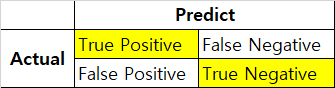

그러므로 각 모델의 accuracy(전체 정확도) 뿐만 아니라

recall = true positive / true positive + false negative

precision = true positive / true positive + false positive

recall 재현율(실제 독 있는 것중 얼마나 정확히 예측했는지)

precision 정밀도(독 있다고 예측한 것 중 실제 독이 얼마나 있는지)

### 그러나 실제 상황에서 False Negative(독버섯을 독 없다고 판단하는)가 가장 위험하므로 recall을 고려해야 함.

#### VGG16 Score
* Accuracy: 0.89
* Precision: 0.91
* Recall: 0.87
* F1 score: 0.89

### Googlenet Score
* Accuracy: 0.91
* Precision: 0.89
* Recall: 0.94
* F1 score: 0.91

그러므로 GoogleNet을 선택해야 한다.